In [1]:
'''------------------------------------------------------------------
LSTM Training
Version: V1.7
Modified: 06.11.2024
William Siegle
---------------------------------------------------------------------
notebook can be converted to python script using: 
(python -m) jupytext --to py FILENAME.ipynb
------------------------------------------------------------------'''
from pathlib import Path

# SETTINGS ---------------------------------------------------------------------
CONFIG = {
    # SYSTEM: ---------------------------------------------------------------------
    "GPU_SELECT":       0, # {None, 0,1,2,3}, None: CPU only
    "INPUT_LOCATION":   Path("final_2", "trips_processed_resampled"),
    "PTH_LOCATION":     Path("src", "models", "pth"),

    # PREPROCESSING: --------------------------------------------------------------
    "TRAIN_VAL_TEST":   [0.8, 0.15, 0.05], # [train, val, test]
    "MAX_FILES":        100, #None, # None: all files
    
    # TORCH: ----------------------------------------------------------------------
    "SEED"  :           42,
    "BATCH_SIZE":       2048,   # [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
    "NUM_EPOCHS":       10,
    "LEARNING_RATE":    5e-3,   # 0.001 lr
    "HIDDEN_SIZE":      256,
    "NUM_LAYERS":       2,
    "DROPOUT":          0.2,
    "SEQ_LEN":          100
}

for key in CONFIG: globals()[key] = CONFIG[key]

In [2]:
# ------------ LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  --------------
import sys, os
global ROOT, DATA_PATH
ROOT = Path('../..').resolve()
print(f"{'-'*60}\nDirectories:\n  {ROOT}:\t\t\t{', '.join([_.name for _ in ROOT.glob('*/')])}")
sys.path.append(os.path.abspath(ROOT))
from data import get_data_path  # paths set in "data/__init__.py"
DATA_PATH = get_data_path()
print(f"  {DATA_PATH}:\t\t\t{', '.join([_.name for _ in DATA_PATH.glob('*/')])}")
# ----------------------------------------------------------------------------------------
from src.utils.TripDataset import TripDataset
from src.utils.train_model import *

------------------------------------------------------------
Directories:
  C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-eR-PINN:			.git, archive, data, project, ref, src, test
  C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data:			final, final_2, processed, trips_processed_final, trips_processed_pickles, trips_processed_resampled, y_true


In [3]:
# IMPORTS ---------------------------------------------------------------------
global IS_NOTEBOOK
IS_NOTEBOOK = False
try:    # if running in IPython
    shell = get_ipython().__class__.__name__ # type: ignore 
    #%reset -f -s
    %matplotlib inline
    from IPython.display import display, HTML, Javascript
    from IPython.core.magic import register_cell_magic
    from IPython.display import clear_output
    @register_cell_magic    # cells can be skipped by using '%%skip' in the first line
    def skip(line, cell): return
    from tqdm.notebook import tqdm # type: ignore
    IS_NOTEBOOK = True
    print(f"{'-'*60}\nRunning in notebook mode")
except (NameError, ImportError):    # if running in script
    from tqdm import tqdm
    from tabulate import tabulate
    print(f"{'-'*60}\nRunning in script mode")
    
    
# ---------------------------------------------------------------------
# IMPORTS ---------------------------------------------------------------------
import math, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from copy import deepcopy
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#from torchinfo import summary
#import pickle
#import random
#from scipy.signal import savgol_filter

import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.parameter import Parameter
from torch.nn.utils.rnn import pack_sequence
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from torchmetrics.functional import mean_squared_error
torch.set_default_dtype(torch.float32)
torch.manual_seed(SEED);

# METRICS ---------------------------------------------------------------------
from sklearn.metrics import root_mean_squared_error
from torchmetrics.functional import mean_squared_error
from pytorch_forecasting.metrics import MASE

from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing import Pipeline

------------------------------------------------------------
Running in notebook mode


___
LOCATE DEVICES & SYSTEM FOLDERS

In [4]:
# DEVICE SELECTION ---------------------------------------------------------------------
global DEVICE
print(f"{'-'*60}\nTorch version: ", torch.__version__)
if not torch.cuda.is_available() or GPU_SELECT is None:
    DEVICE = torch.device("cpu")
else:
    DEVICE = torch.device(f"cuda:{GPU_SELECT}")
print(f"Using: -->  {str(DEVICE).upper()}")


------------------------------------------------------------
Torch version:  2.3.1+cpu
Using: -->  CPU


___
DATA PREPROCESSING

In [5]:
# FILE SOURCES ---------------------------------------------------------------
input_folder = Path(DATA_PATH, INPUT_LOCATION) # Trip parquet files
pth_folder = Path(ROOT, PTH_LOCATION)
print(f"{'-'*60}\nInput Data:\t{input_folder}\nStore model in:\t{pth_folder}")

# PREPARE TRAIN & TEST SET ---------------------------------------------------
all_files = [Path(input_folder, f) for f in os.listdir(input_folder) if f.endswith(".parquet")]
files = all_files[:MAX_FILES]
print(f"{'-'*60}\nTotal Files: {len(files)}\n{'-'*60}")
# ---------------------------------------------------
df = pd.read_parquet(Path(input_folder, random.choice(files)), engine='fastparquet')
all_signals = df.columns
assert len(all_signals) == 57

# get df stats:
# df.info()
'''
from scipy.stats import shapiro
nd = []
for sig in df.columns:
    if np.ptp(df[sig]) != 0:
        _ , p = shapiro(df[sig])
        if p > 0.05:
            nd.append(sig)
print(f"{'-'*60}\nNormal Distributed Signals: {len(nd)}\n{'-'*60}")
''';

------------------------------------------------------------
Input Data:	C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\final_2\trips_processed_resampled
Store model in:	C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-eR-PINN\src\models\pth
------------------------------------------------------------
Total Files: 100
------------------------------------------------------------


In [6]:
# INPUT & TARGET SPECIFICATION ---------------------------------------------------
# these signals are required for the physical Model calculation:
base_signals = ["signal_time", "hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 
"hv_batpwr_cval_bms1", "emot_pwr_cval","bs_roadincln_cval", "roadgrad_cval_pt"]

# these signals have to be dropped in order for appropriate training:
columns_to_drop = ["hv_bat_soc_cval_bms1", "latitude_cval_ippc", "longitude_cval_ippc", "signal_time", "signal_ts"]

# ---------------------------------------------------
target_column = "hv_batmomavldischrgen_cval_1"
input_columns = all_signals.drop(columns_to_drop + [target_column])

# ---------------------------------------------------
# SELECT RUN:
input_columns = input_columns
# input_columns = ["hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "hv_batpwr_cval_bms1", "emot_pwr_cval","bs_roadincln_cval", "roadgrad_cval_pt"]
# input_columns = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "bs_roadincln_cval", "vehweight_cval_pt"]
# input_columns = [i for i in input_columns if i not in base_signals]

In [7]:
# FEATURE NORMALIZATION/SCALING -----------------------------------------------------------------
scaler = MaxAbsScaler() 
target_scaler = MinMaxScaler(feature_range=(0, 1))

In [8]:
# DATA SET SPLITTING -----------------------------------------------------------------------
# train_subset, test_subset = train_test_split(files, test_size=0.2, random_state=1)
train_subset, val_subset, test_subset = random_split(files, TRAIN_VAL_TEST)

In [9]:
# GENERATE DATALOADERS  ---------------------------------------------------------------
# Note: 1. the scaler will be fitted only on the training data set
#       2. shuffling is prohibited to maintain the time series order

# TRAIN  ------------------------------------------------------------
train_dataset = TripDataset(train_subset, input_columns, target_column, scaler, target_scaler, fit=True)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=False)

# VAL ------------------------------------------------------------
val_dataset = TripDataset(val_subset, input_columns, target_column, scaler, target_scaler, fit=False)
val_loader = DataLoader(val_dataset, BATCH_SIZE, shuffle=False)

# TEST ------------------------------------------------------------
test_dataset = TripDataset(test_subset, input_columns, target_column, scaler, target_scaler, fit=False)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)

# Print the size of the datasets ----------------------------------
print(f"{'-'*60}\nTrain size:  {len(train_dataset)}\t\t(Files: {len(train_subset)})")
print(f'Val. size:   {len(val_dataset)}\t\t(Files: {len(val_subset)})')
print(f'Test size:   {len(test_dataset)}\t\t(Files: {len(test_subset)}) \n {"-"*60}')
if train_dataset.__len__() != sum(len(data) for data in train_dataset.data): print("Warning: Train Dataset Length Mismatch")

subset_files = {"train":    list(train_loader.dataset.file_list),
                "val":      list(val_loader.dataset.file_list),
                "test":     list(test_loader.dataset.file_list)}
print([os.path.basename(_) for _ in subset_files["train"][:3]])

fitting Scalers: MaxAbsScaler, MinMaxScaler
Done. Create DataSets...
------------------------------------------------------------
Train size:  176385		(Files: 80)
Val. size:   24642		(Files: 15)
Test size:   8612		(Files: 5) 
 ------------------------------------------------------------
['v_id983V101_trip130_2.parquet', 'v_id983V101_trip173.parquet', 'v_id983V101_trip146_2.parquet']


___
NETWORK ARCHITECTURE

In [10]:
# LSTM NETWORK -----------------------------------------------------------------------
class LSTM1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, device = DEVICE): #, num_classes, seq_length):
        super(LSTM1, self).__init__()

        self.input_size = input_size    # input size
        self.hidden_size = hidden_size  # hidden state
        self.num_layers = num_layers    # number of layers
        #self.num_classes = num_classes  # number of classes
        #self.seq_length = seq_length    # sequence length

        # LSTM CELL --------------------------------
        self.lstm = nn.LSTM(
            self.input_size,            # The number of expected features in the input x
            self.hidden_size,           # The number of features in the hidden state h
            self.num_layers,            # Number of recurrent layers for stacked LSTMs. Default: 1
            batch_first = True,         # If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Default: False
            bias = True,                # If False, then the layer does not use bias weights b_ih and b_hh. Default: True
            dropout = 0.30,             # usually: [0.2 - 0.5] ,introduces a Dropout layer on the outputs of each LSTM layer except the last layer, (dropout probability). Default: 0
            bidirectional = False,      # If True, becomes a bidirectional LSTM. Default: False
            proj_size = 0,              # If > 0, will use LSTM with projections of corresponding size. Default: 0
            device = DEVICE) 
        
        # --------------------------------
        #self.fc_1 =  nn.Linear(hidden_size, 128)  # fully connected 1
        #self.fc = nn.Linear(128, num_classes)     # fully connected last layer
        # --------------------------------
        self.relu = nn.ReLU()
        self.fc_test =  nn.Linear(hidden_size, 1)

    
    def forward(self, input, batch_size = None):
        '''        
        # initial hidden and internal states
        # --------------------------------
        h_0 = torch.zeros(self.num_layers, input.size(0) if batch_size is None else batch_size, self.hidden_size)
        c_0 = torch.zeros(self.num_layers, input.size(0) if batch_size is None else batch_size, self.hidden_size)  
        # --------------------------------
        out = self.relu(hn.view(-1, self.hidden_size)) # reshaping the data for Dense layer next
        out = self.fc_1(out) # first Dense
        out = self.relu(out) # relu
        out = self.fc(out) # Final Output
        '''

        # Propagate input through LSTM
        # --------------------------------
        # output, (hn, cn) = self.lstm(input, (h_0, c_0)) # lstm with input, hidden, and internal state
        # input shape:      (batch_size, seq_length, input_size)
        # output shape:     (batch_size, seq_length, hidden_size)
        # --------------------------------
        out, _ = self.lstm(input)


        # ouput layers
        # --------------------------------
        out = self.relu(out) # relu
        out = self.fc_test(out[:, -1, :])  
        #out = self.fc_test(out)

        return out

In [11]:
# FCNN NETWORK -----------------------------------------------------------------------
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        
        # here, our linear layer will have an input of 200, not 100 as before:
        self.fc1 = nn.Linear(200,5)  
        self.fc2 = nn.Linear(5,10)   
        self.fc3 = nn.Linear(10,100) # but the output remains 100
        
          
    def forward(self, x):
        # we have to flatten our 20x2x100 to a 20x200:
        x = x.view(x.size(0),-1)     # x.size(0) is 20, and -1 is a shortcut for "figure out the other number for me please!"
        
        # the rest proceeds as before:
        x = F.relu(self.fc1(x))      
        x = F.relu(self.fc2(x))
        x = self.fc3(x)              
        return x
        
#net = FCNN()
#print(net) 

In [12]:
# MODEL CONFIGURATION -----------------------------------------------------------------------

# LAYERS --------------------------------
input_size = len(input_columns)     # expected features in the input x
hidden_size = 100                   # features in the hidden state h
num_layers = 2                      # recurrent layers for stacked LSTMs. Default: 1
num_classes = 1                     # output classes (=1 for regression)

# INSTANTIATE MODEL --------------------
model = LSTM1(input_size, hidden_size, num_layers).to(DEVICE)  #, num_classes, seq_length).to(DEVICE)

___
TRAINING SETUP

In [13]:
# TRAINING CONFIGURATION -----------------------------------------------------------------------

# OPTIMIZER -----------------------------
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE,
    weight_decay = 1e-4      # weight decay coefficient (default: 1e-2)
    #betas = (0.9, 0.95),    # coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
    #eps = 1e-8,             # term added to the denominator to improve numerical stability (default: 1e-8)
)

# LR SCHEDULER -----------------------------
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 2, factor = 0.5, min_lr = 1e-6)

# LOSS FUNCTION ----------------------------------------------------------------
def loss_fn(model_output, target):
    loss = F.mse_loss(model_output, target) # mean-squared error for regression
    return loss

# or define criterion function:
criterion_list = [nn.MSELoss(), nn.L1Loss(), nn.SmoothL1Loss(), nn.HuberLoss(), MASE()]

criterion = nn.SmoothL1Loss()

# ------------------------------------------------------------------------------
# print Model and Optimizer state_dicts
print(f"{'-'*60}\n", model, f"{'-'*60}\nModel state_dict:")
for param_tensor in model.state_dict(): print(f"{param_tensor}:\t {model.state_dict()[param_tensor].size()}")
print(f"{'-'*60}\n{optimizer}\n{'-'*60}\n{'-'*60}\n")

------------------------------------------------------------
 LSTM1(
  (lstm): LSTM(51, 100, num_layers=2, batch_first=True, dropout=0.3)
  (relu): ReLU()
  (fc_test): Linear(in_features=100, out_features=1, bias=True)
) ------------------------------------------------------------
Model state_dict:
lstm.weight_ih_l0:	 torch.Size([400, 51])
lstm.weight_hh_l0:	 torch.Size([400, 100])
lstm.bias_ih_l0:	 torch.Size([400])
lstm.bias_hh_l0:	 torch.Size([400])
lstm.weight_ih_l1:	 torch.Size([400, 100])
lstm.weight_hh_l1:	 torch.Size([400, 100])
lstm.bias_ih_l1:	 torch.Size([400])
lstm.bias_hh_l1:	 torch.Size([400])
fc_test.weight:	 torch.Size([1, 100])
fc_test.bias:	 torch.Size([1])
------------------------------------------------------------
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0.0001
)
----------------------------

___
NETWORK TRAINING

In [14]:
# NETWORK TRAINING -----------------------------------------------------------------
trained = train_model(
    model = model, 
    optimizer = optimizer,
    scheduler = scheduler, 
    loss_fn = criterion, 
    train_loader = train_loader,
    val_loader = val_loader, 
    num_epochs = NUM_EPOCHS, 
    device = DEVICE, 
    is_notebook = IS_NOTEBOOK
    )

Training Started.	Process ID: 17844 
------------------------------------------------------------
Model: LSTM1		Parameters on device: CPU
------------------------------------------------------------
Train/Batch size:	176385 / 2048
Loss:			SmoothL1Loss()
Optimizer:		AdamW
LR:			0.005
Weight Decay:		0.0001
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------------
Training Completed.	Execution Time: 00:01:27



In [15]:
# SAVE MODEL  -----------------------------------------------------------------
# create unique model name
model_name = f'{model.__class__.__name__}_{datetime.now().strftime("%y%m%d_%H%M%S")}'
model_destination_path = Path(pth_folder, model_name + ".pth")

# add the splitted data subset information to save dict
trained['subset_files'] = subset_files
# save the model & print info
torch.save(trained, model_destination_path)
print(f"Model saved to:\t {model_destination_path}\n{'-'*60}\nSize: {os.path.getsize(model_destination_path) / 1e6:.2f} MB\n{'-'*60}")
if os.path.getsize(model_destination_path) > 100 * 1024**2: print("--> Warning: The saved model size exceeds 100MB!")

Model saved to:	 C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-eR-PINN\src\models\pth\LSTM1_241110_194647.pth
------------------------------------------------------------
Size: 1.73 MB
------------------------------------------------------------


In [23]:
# LOAD MODEL AT CHECKPOINT -----------------------------------------------------------------
model_destination_path = Path(pth_folder, "LSTM1_241110_194647.pth")

# -----------------------------------------------------------------
checkpoint = torch.load(model_destination_path, weights_only=False, map_location=DEVICE if torch.cuda.is_available() else torch.device('cpu'))
for key in ["model", "loss_fn", "training_table", "train_losses", "val_losses", "epoch"]: exec(f"{key} = checkpoint[key]")

# configure model and optimizer:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Move the model and its parameters to the CPU
try:
    if torch.cuda.is_available() and GPU_SELECT is not None:
        model.to(DEVICE)
    else:
        model.to(torch.device("cpu"))
except:
    model.to(torch.device("cpu"))

model.eval(); # set model to evaluation mode for inference
print(f"Model loaded from:\t {model_destination_path}\n{'-'*60}")
print(f"Model: {model.__class__.__name__}\t\tParameters on device: {next(model.parameters()).device}\n{'-'*60}\n"
        f"Train/Batch size:\t{len(train_loader.dataset)} / {train_loader.batch_size}\n"
        f"Loss:\t\t\t{loss_fn}\nOptimizer:\t\t{optimizer.__class__.__name__}\nLR:\t\t\t"
        f"{optimizer.param_groups[0]['lr']}\nWeight Decay:\t\t{optimizer.param_groups[0]['weight_decay']}\n{'-'*60}\n", model)

# get file list of test subset
test_files = checkpoint["subset_files"]["test"]

Model loaded from:	 C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-eR-PINN\src\models\pth\LSTM1_241110_194647.pth
------------------------------------------------------------
Model: LSTM1		Parameters on device: cpu
------------------------------------------------------------
Train/Batch size:	176385 / 2048
Loss:			SmoothL1Loss()
Optimizer:		AdamW
LR:			0.005
Weight Decay:		0.0001
------------------------------------------------------------
 LSTM1(
  (lstm): LSTM(51, 100, num_layers=2, batch_first=True, dropout=0.3)
  (relu): ReLU()
  (fc_test): Linear(in_features=100, out_features=1, bias=True)
)


In [ ]:
# RESUME TRAINING -----------------------------------------------------------------
resume = False
if resume: 
    NUM_EPOCHS += 5 # train for 2 more epochs
    trained = train_model(
        model = model, 
        optimizer = optimizer,
        scheduler = scheduler, 
        loss_fn = criterion, 
        train_loader = train_loader,
        val_loader = val_loader, 
        state = checkpoint,
        num_epochs = NUM_EPOCHS, 
        device = DEVICE, 
        is_notebook = IS_NOTEBOOK)

Training Started.	Process ID: 17844 
------------------------------------------------------------
Model: LSTM1		Parameters on device: CPU
------------------------------------------------------------
Train/Batch size:	176385 / 2048
Loss:			SmoothL1Loss()
Optimizer:		AdamW
LR:			0.005
Weight Decay:		0.0001
------------------------------------------------------------


  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/87 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------------
Training Completed.	Execution Time: 00:02:08



ValueError: x and y must have same first dimension, but have shapes (15,) and (10,)

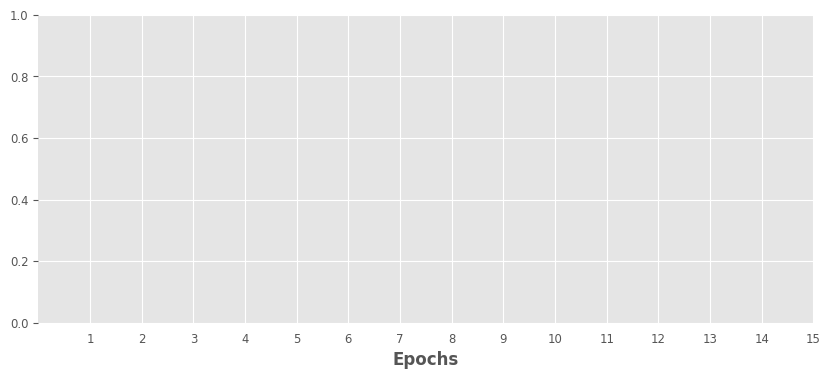

In [25]:
# get DataFrame of training metrics:
training_df = pd.DataFrame(training_table, columns=["Epoch", "Iteration", "Batch Loss", "Train Loss"])
# Extract the 'Train Loss' column and compare with the train_losses list
train_loss_column = training_df['Train Loss'].replace(['',' '], np.nan).dropna().astype(float).values
if any(abs(train_loss_column - train_losses) > 1e-3): 
    print("Extracted and original Train Losses are not equal. Please check metrics table.")

# -------------------------------------
# plot training performance:
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.set_xlabel('Epochs')
ax1.set_xticks(range(1, NUM_EPOCHS + 1))

plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='train_loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='val_loss')
plt.style.use('ggplot'); plt.yscale('log'); fig.tight_layout(); plt.legend();

plt.text(0.8, 0.3, f"Train: {train_losses[-1]:.3e}\nVal:    {val_losses[-1]:.3e}", transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5));

___
EVALUATION / POST-PROCESSING

In [20]:
# EVALUATION -----------------------------------------------------------------
model.eval() # set model to evaluation mode
test_loss = 0
all_outputs, all_targets = [], []

with torch.no_grad():
    for iter, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)

        # Collect all outputs and targets
        all_outputs.append(outputs.detach().cpu().numpy())
        all_targets.append(targets.detach().cpu().numpy())

        loss = criterion(outputs.squeeze(), targets)
        test_loss += loss.item()

# Inverse-transform on all outputs and targets for evaluation
scaled_outputs = target_scaler.inverse_transform(np.concatenate(all_outputs, axis=0).reshape(-1, 1))
scaled_targets = target_scaler.inverse_transform(np.concatenate(all_targets, axis=0).reshape(-1, 1))


test_loss /= len(test_loader)
print(f"Test Loss:  {test_loss:.4f}")
print(f"Iterations: {iter}/{math.floor(len(test_loader.dataset) / test_loader.batch_size)}")
print(f"RMSE: {root_mean_squared_error(scaled_targets, scaled_outputs):.4f}")
print(f"Standard Deviation: {np.std(scaled_targets - scaled_outputs):.4f}")

Test Loss:  0.0221
Iterations: 4/4
RMSE: 70.5889
Standard Deviation: 61.6254


In [26]:
test_dataset = TripDataset(random.sample(test_files, 1), scaler, target_scaler)
test_loader_2 = DataLoader(test_dataset, batch_size=1, shuffle=False)
print(len(test_files))

model.eval()
y_pred = []
with torch.no_grad():
    for inputs, targets in test_loader_2:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)
        y_pred.append(torch.mean(outputs).item())

y_pred = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_true = target_scaler.inverse_transform(np.array(test_loader_2.dataset.targets[0]).reshape(-1, 1))

###############################################
# PLOT PREDICTION -----------------------------------------------------------------
plt.figure(figsize=(18,4)); plt.xlabel('Time in s'); plt.ylabel('Battery Energy in kWh'); plt.title('Time-Series Prediction')
plt.plot(y_true, label='Actual Data') # actual plot
plt.plot(np.arange(0, len(y_true), 1), y_pred, label='Predicted Data') # predicted plot
plt.legend()
plt.text(0.01, 0.02, f"RMSE: {root_mean_squared_error(y_true, y_pred):.4f}", transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.figure(figsize=(18,4)); plt.xlabel('Time in s'); plt.ylabel('Battery Energy in kWh'); plt.title('Time-Series Prediction (Smoothed)')
plt.plot(savgol_filter(y_true.flatten(), window_length=60, polyorder=3), label='Actual Data (Smoothed)') # actual plot
plt.plot(np.arange(0, len(y_true), 1), savgol_filter(y_pred.flatten(), window_length=60, polyorder=3), label='Predicted Data (Smoothed)') # predicted plot
plt.legend();

TypeError: TripDataset.__init__() missing 2 required positional arguments: 'scaler' and 'target_scaler'